# <b><font color='#009e74'>Functional Characterisation via Evolutionary Scale Models (FunC-ESMs) - prediction notebook </font></b>

Generation of FunC-ESMs molecular mechanism predictions for variants and labels for the relevance of the structure and function of residues using deep learning representations of Evolutionary Scale Models (ESMs).
<br>

<p> A Colaboratory implementation of <b> Cagiada.M &#10013, Jonsson N. &#10013, Lindorff-Larsen K., </b> - <a href=https://doi.org/"> Decoding molecular mechanisms for loss of function variants in the human proteome</a>
. Source code is available on the project <a href=hhttps://github.com/KULL-Centre/_2022_functional-sites-cagiada">Github</a> page.
</p>

<p> &#10013 : equal contributions from the authors </p>

<br>

The notebook used as input:
- a query protein <b><font color='#009e74'>sequence</font></b>;
- an <b><font color='#009e74'>AlphaFold2 structure prediction</font></b> of the query protein (downloaded from AF2 database or uploaded by the user - PDB format);

The output files generated include ESM-1B and ESM-IF marginal score predictions, FunC-ESMs predictions for the mechanism of variants and the biochemical role of residues.
The predictions can be downloaded in CSV or Excel format.

\\

****
\\

### <b>PRACTICALITIES</b>

- This notebook <b><font color='#d55c00'>must be</font></b> running in a Colab GPU session (go to the top menu tab: `Runtime`->  `Change runtime type` -> select `GPU` and confirm.

- Cells labelled <b><font color='#f0e422'>PRELIMINARY OPERATIONS </font></b>  must be run <b><font color='#d55c00'>ONE TIME</font></b>  at the start and <b>SKIPPED</b> for new predictions.

- Multiple predictions can be run in a single session by uploading the data for a new query protein in the cell: <b><font color='#56b4e9'> DATA UPLOADING</font></b>.

- For structural stability evaluations with ESM-IF, the **input structure** can have <b><font color='#d55c00'>one</font></b> or <b><font color='#d55c00'>multiple</font></b> chains. A **target** chain must be selected, while the remaining chains, if present, can be excluded or retained (to assess stability in a complex). The presence or absence of the remaining chains **WILL INFLUENCE** the stability predictions and thus the classification.

- The input <b><font color='#d55c00'>query</font></b>  and <b><font color='#d55c00'>structure</font></b> sequences <b><font color='#d55c00'>MUST MATCH</font></b>.

- If you wish to download the predictions you can find them in the <b>/content/FunC-ESMs_outputs</b> folder, if you wish to download <b>ALL</b>  the prediction as zip file run the last cell called <b><font color='#56b4e9'>DOWNLOAD RESULTS </font>


In [1]:
#@title <b><font color='#f0e422'>PRELIMINARY OPERATIONS:</font> Install dependencies

#@markdown Run the cell to downaload and install all the extra necessaries packages <b>(~3m)</b>, including:
#@markdown - ESM-IF, ESM-1B (libraries and parameters)
#@markdown - Torch libraries: torch-scatter,-sparse,-cluster,spline-conv,-geometric
#@markdown - Python libraries: biopython, biotite, PrismParser

%%time
import os,time,subprocess,re,sys,shutil
from google.colab import files
import torch
import numpy as np
import pandas as pd
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt

def format_pytorch_version(version):
  return version.split('+')[0]

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)
CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

ESMIF_model_name = "esm_if1_gvp4_t16_142M_UR50.pt"
ESM1B_model_name = "esm1b_t33_650M_UR50S.pt"
ESM1B_model_contact = "esm1b_t33_650M_UR50S-contact-regression.pt"

os.system("apt-get install aria2 -qq")
if not os.path.isfile(ESMIF_model_name) or not os.path.isfile(ESM1B_model_name):

  # download esmfold params
  print("installing downloading ESM-1b parameters... (in background)")
  os.system(f"aria2c -x 16 https://sid.erda.dk/share_redirect/hcoUfJRcgG --out={ESM1B_model_contact} &")
  os.system(f"aria2c -x 16 https://sid.erda.dk/share_redirect/DKJpFWiwkf --out={ESM1B_model_name} &")

  if not os.path.isfile("finished_install"):
    # install libs
    print("installing libs...")

    os.system(f"pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html")
    os.system(f"pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html")
    os.system(f"pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html")
    os.system(f"pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html")
    os.system(f"pip install torch-geometric")
    os.system(f"pip install biopython")
    os.system(f"pip install biotite")
    os.system(f"pip install alive-progress")

    # import prismparser
    !git clone https://github.com/KULL-Centre/PrismData.git
    !mv /content/PrismData/PrismData.py /content/PrismData.py
    !rm -r /content/PrismData

    print("installing esmfold...")
    # install esmfold
    os.system(f"pip install git+https://github.com/matteo-cagiada/esm.git")
    os.system("touch finished_install")

    #wait for Params to finish downloading...
    while not os.path.isfile(ESM1B_model_name):
      time.sleep(5)
    if os.path.isfile(f"{ESM1B_model_name}.aria2"):
      print("finishing downloading parameters ESM-1b...")
    while os.path.isfile(f"{ESM1B_model_name}.aria2"):
      time.sleep(5)

  # download esmfold params
  print("installing downloading ESM-IF parameters...")

  os.system(f"aria2c -x 16 https://sid.erda.dk/share_redirect/eIZVVNEd8B --out={ESMIF_model_name}")

from PrismData import PrismParser
from alive_progress import alive_bar

## Verify that pytorch-geometric is correctly installed

import esm

from esm.inverse_folding.util import load_structure, extract_coords_from_structure,CoordBatchConverter
from esm.inverse_folding.multichain_util import extract_coords_from_complex,_concatenate_coords,load_complex_coords

print("--> Installations succeeded")

installing downloading ESM-1b parameters... (in background)
installing libs...
Cloning into 'PrismData'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (18/18), 24.69 KiB | 12.35 MiB/s, done.
Resolving deltas: 100% (4/4), done.
installing esmfold...
finishing downloading parameters ESM-1b...
installing downloading ESM-IF parameters...
--> Installations succeeded
CPU times: user 5.68 s, sys: 1.05 s, total: 6.73 s
Wall time: 3min 5s


In [2]:
#@title <b><font color='#f0e422'>PRELIMINARY OPERATIONS:</font> Load EXTRA functions
#@markdown Run the cell to load the required dictionaries and functions

alphabetAA_L_D_reordered={0:'R',1:'H',2:'K',3:'D',4:'E',5:'S',6:'T',7:'N',8:'Q',9:'C',10:'G',11:'P',12:'A',13:'V',14:'I',15:'L',16:'M',17:'F',18:'Y',19:'W'}
alphabetAA_D_D_reordered={14:0,6:1,8:2,2:3,3:4,15:5,16:6,11:7,13:8,1:9,5:10,12:11,0:12,17:13,7:14,9:15,10:16,4:17,19:18,18:19}
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
alphabet_class_variant_d_l={0:'WT-like',1:'Stable-but-inactive',2:'Total-loss'}
alphabet_class_residue_d_l={0:'Tolerant',1:'Functionally-relevant',2:'Structurally-critical',4:'Mixed'}

def ESM1B_pred(model,alphabet,sequence=None):

  print('--> running ESM1b')

  logits=run_1B(sequence,model,alphabet)

  mutation_list,outscores=scores_variants(sequence,logits,alphabet)

  print('<-- ESM1b run completed')

  return mutation_list,outscores

def ESMIF_pred(model,alphabet,sequence=None,coords=None,cmplx=None,chain_targer=None):

  print('--> running ESM-IF')

  logits=run_IF(coords,sequence,model,alphabet,cmplx=is_complex,chain_target=chain_id)

  mutation_list,outscores=scores_variants(sequence,logits,alphabet)

  print('<-- ESM-IF run completed')

  return mutation_list,outscores

def run_IF(coords,sequence,model,alphabet,cmplx=False,chain_target='A'):

  device = next(model.parameters()).device

  batch_converter = CoordBatchConverter(alphabet)
  batch = [(coords, None, sequence)]
  coords, confidence, strs, tokens, padding_mask = batch_converter(
      batch, device=device)

  prev_output_tokens = tokens[:, :-1].to(device)
  target = tokens[:, 1:]
  target_padding_mask = (target == alphabet.padding_idx)

  logits, _ = model.forward(coords, padding_mask, confidence, prev_output_tokens)

  logits_swapped=torch.swapaxes(logits,1,2)
  token_probs = torch.log_softmax(logits_swapped, dim=-1)

  return token_probs[0,:,:]

def run_1B(sequence,model,alphabet):
  batch_converter = alphabet.get_batch_converter()

  data = [
      ("protein1", sequence),
  ]
  batch_labels, batch_strs, batch_tokens = batch_converter(data)

  all_token_probs = []
  with alive_bar(batch_tokens.size(1),force_tty=True,spinner='squares',bar='bubbles') as bar:

    for i in range(batch_tokens.size(1)):
        bar()
        batch_tokens_masked = batch_tokens.clone()
        batch_tokens_masked[0, i] = alphabet.mask_idx

        logits=model(batch_tokens_masked.cuda())["logits"]
        token_probs = torch.log_softmax(logits, dim=-1)

        all_token_probs.append(token_probs[:, i])  # vocab size

  token_probs = torch.cat(all_token_probs, dim=0).unsqueeze(0)

  return token_probs[0,1:,:]

def scores_variants(sequence,token_probs,alphabet):

  mutation_list=[]
  outscores=np.empty((len(sequence),20),dtype=float)
  outscores[:]=np.nan

  for i,n in enumerate(sequence):
      for j in range(1,21):
          if alphabetAA_D_L[j]!=n:
              mutation_list.append(n+str(i+1)+alphabetAA_D_L[j])
              outscores[i,j-1]=masked_marginals(mutation_list[-1],sequence, token_probs, alphabet)
          else:
              mutation_list.append(n+str(i+1)+"=")
              outscores[i,j-1]=0.

  return mutation_list, outscores

def masked_marginals(mut, sequence, token_probs, alphabet):
  wt, idx, mt = mut[0], int(mut[1:-1]) - 1, mut[-1]
  assert sequence[idx] == wt, "The listed wildtype does not match the provided sequence"

  wt_encoded, mt_encoded = alphabet.get_idx(wt), alphabet.get_idx(mt)

  score = token_probs[idx, mt_encoded] - token_probs[idx, wt_encoded]
  return score.item()

def classify_variants(esm1b_scores,esmif_scores,esm1b_threshold=-6.5,esmif_threshold=-7.0):

  print('--> FunC-ESMs classification ...')

  variant_class=np.zeros((esm1b_scores.shape[0],esm1b_scores.shape[1]),dtype=float)
  for i in range(esm1b_scores.shape[0]):
    for j in range(esm1b_scores.shape[1]):

      if esm1b_scores[i,j] < esm1b_threshold:
          if esmif_scores[i,j] < esmif_threshold:
              variant_class[i,j]=2
          else:
              variant_class[i,j]=1

  return variant_class

def classify_residues(variant_class_matrix):
  res_class=np.empty(variant_class_matrix.shape[0],dtype=float)
  res_class[:]=np.nan

  for i in range(variant_class_matrix.shape[0]):
      res_class[i]=retrieve_res_class(variant_class_matrix[i,:])

  print('<-- FunC-ESMs classification completed')
  return res_class

def retrieve_res_class(variants_class):
  unique_values, counts = np.unique(variants_class, return_counts=True)
  if np.any(counts/np.sum(counts) >0.5):
      return unique_values[np.argmax(counts)]
  else:
      return 4.
  return res_class


def heatmap_values_reordered(ext_score,label_cm,WT_mask,x,title_figure='',where_save='./',figs=[30,7],xtick_spacing=10,colour_map='RdBu',min_colour=-15):
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    mpl.rcParams['axes.labelsize']  = 20

    score=np.copy(ext_score)

    for i in range(score.shape[1]):
        #print(i,score[:,i][0:10])
        score[:,alphabetAA_D_D_reordered[i]]=ext_score[:,i]
        #print(alphabetAA_D_D_reordered[i],score[:,alphabetAA_D_D_reordered[i]][0:10])

    score_nan=np.copy(ext_score)
    score_nan[:]=np.inf

    for i in range(score.shape[0]):
        for j in range(score.shape[1]):
                if np.isnan(ext_score[i,j])==True and WT_mask[i]!=alphabetAA_D_L[j+1]:

                    score_nan[i,alphabetAA_D_D_reordered[j]]=1
                    #print(WT_mask[i],alphabetAA_D_D_reordered[alphabetAA_D_L[j+1]])

    fig, ax = plt.subplots(figsize=(figs[0],figs[1]),layout='tight')
    ylabels=[ alphabetAA_L_D_reordered[i] for i in range(0,20)]

    pos=ax.imshow(np.transpose(score), aspect = 'auto', cmap=f'{colour_map}_r',vmin=min_colour, vmax=0, interpolation='nearest')
    fig.colorbar(pos, label=label_cm)

    #current_cmap = mpl.cm.get_cmap()
    current_cmap = plt.get_cmap()
    current_cmap.set_bad(color='gray')


    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels)

    #ax.xaxis.set_ticks(np.arange(1, end, stepsize))

    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("Mutation to")
    plt.xlabel("residue")
    plt.ylim(-0.5,19.5)
    plt.xlim(x[0]-0.5,x[1]+0.5)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start+0.5, end, xtick_spacing))
    ax.tick_params(axis='x',rotation=90)
    ax.tick_params(axis='y',rotation=90)
    ax.set_title(title_figure,fontsize=20)
    tmp=np.empty((len(WT_mask),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT_mask)):
        tmp[i,alphabetAA_D_D_reordered[alphabetAA_L_D[WT_mask[i]]-1]]=1

    plt.imshow(score_nan.T, cmap='Dark2_r', aspect = 'auto',interpolation='nearest')
    plt.imshow(tmp.T, cmap='gnuplot_r', aspect = 'auto',interpolation='nearest')
    plt.savefig(os.path.join(where_save,title_figure+'_variant_map.pdf'),dpi=300,bbox_inches='tight')
    plt.show()


def heatmap_classes_reordered(ext_score,label_cm,WT_mask,x,title_figure='',where_save='./',WT_cmap='gnuplot_r',nan_cmap='Dark2_r',figs=[30,7],xtick_spacing=10):

  mpl.rcParams['xtick.labelsize'] = 18
  mpl.rcParams['ytick.labelsize'] = 18
  mpl.rcParams['axes.labelsize']  = 20

  score=np.copy(ext_score)

  for i in range(score.shape[1]):
      #print(i,score[:,i][0:10])
      score[:,alphabetAA_D_D_reordered[i]]=ext_score[:,i]
      #print(alphabetAA_D_D_reordered[i],score[:,alphabetAA_D_D_reordered[i]][0:10])

  score_nan=np.copy(ext_score)
  score_nan[:]=np.inf

  for i in range(score.shape[0]):
      for j in range(score.shape[1]):
              if np.isnan(ext_score[i,j])==True and WT_mask[i]!=alphabetAA_D_L[j+1]:

                  score_nan[i,alphabetAA_D_D_reordered[j]]=1
                  #print(WT_mask[i],alphabetAA_D_D_reordered[alphabetAA_D_L[j+1]])

  fig, ax = plt.subplots(figsize=(figs[0],figs[1]),layout='tight')
  ylabels=[ alphabetAA_L_D_reordered[i] for i in range(0,20)]
  if np.isnan(np.unique(score)).any():
    num_colors=len(np.unique(score))-1
  else:
    num_colors=len(np.unique(score))

  if num_colors==3:
    pos=ax.imshow(np.transpose(score), aspect = 'auto', cmap=mpl.colors.ListedColormap(["#009e74", "#56b4e9","#d55c00"]),interpolation='nearest')
  elif num_colors==4:
    pos=ax.imshow(np.transpose(score), aspect = 'auto', cmap=mpl.colors.ListedColormap(["#009e74", "#56b4e9","#d55c00","#f0e442"]),interpolation='nearest')

  #current_cmap = mpl.cm.get_cmap()
  current_cmap = plt.get_cmap()
  current_cmap.set_bad(color='gray')

  ax.set_yticks([i for i in range(0,20)])
  ax.set_yticklabels(ylabels)

  #ax.xaxis.set_ticks(np.arange(1, end, stepsize))

  plt.grid(axis='both',which='both',alpha=0.4)
  #plt.ylabel("mutation")
  plt.xlabel("residue")
  plt.ylim(-0.5,19.5)
  plt.xlim(x[0]-0.5,x[1]+0.5)
  start, end = ax.get_xlim()
  ax.xaxis.set_ticks(np.arange(start+0.5, end, xtick_spacing))
  ax.tick_params(axis='x',rotation=90)
  ax.tick_params(axis='y',rotation=90)
  ax.set_title(title_figure,fontsize=20)
  tmp=np.empty((len(WT_mask),20),dtype=float)
  tmp[:]=np.inf
  for i in range(0,len(WT_mask)):
      tmp[i,alphabetAA_D_D_reordered[alphabetAA_L_D[WT_mask[i]]-1]]=1

  plt.imshow(score_nan.T, cmap=nan_cmap, aspect = 'auto',interpolation='nearest')
  plt.imshow(tmp.T, cmap=WT_cmap, aspect = 'auto',interpolation='nearest')
  plt.savefig(os.path.join(where_save,title_figure+'_variant_map.pdf'),dpi=300,bbox_inches='tight')
  plt.show()

def residues_classes_reordered(ext_score,x,title_figure='',where_save='./',figs=[20,1],xtick_spacing=10):
  mpl.rcParams['xtick.labelsize'] = 18
  mpl.rcParams['ytick.labelsize'] = 18
  mpl.rcParams['axes.labelsize']  = 20
  fig,ax1 = plt.subplots(1,1,figsize=(figs[0],figs[1]),layout='tight')

  if 4. in ext_score:
    ax1.imshow(ext_score.reshape(1,-1),aspect= 'auto', cmap=mpl.colors.ListedColormap(["#009e74", "#56b4e9","#d55c00","#5A5A5A","#5A5A5A"]))
  else:
      ax1.imshow(ext_score.reshape(1,-1),aspect= 'auto', cmap=mpl.colors.ListedColormap(["#009e74", "#56b4e9","#d55c00"]))

  ax1.set_yticks([])
  plt.xlim(x[0]-0.5,x[1]+0.5)

  start, end = ax1.get_xlim()
  ax1.xaxis.set_ticks(np.arange(start+0.5, end, xtick_spacing))
  ax1.tick_params(axis='x',rotation=90)

  ax1.set_xlabel('residue')
  ax1.set_title(title_figure,fontsize=20)
  plt.savefig(os.path.join(where_save,title_figure+'_residue_class.pdf'),dpi=300,bbox_inches='tight')
  plt.show()

def histogram_data(data_input,range_data,xlabel,title,where_save,sequence=None,wt_score=0.):
  if not sequence is None:
    for idx,wtaa in enumerate(sequence):
      data_input[idx,alphabetAA_L_D[wtaa]-1]=np.nan

  fig,ax=plt.subplots(1,1,figsize=(6,4),layout='tight')
  ax.hist(data_input.flatten(),range=range_data,bins=20,edgecolor='k',facecolor='#56b4e9')
  y_lim=ax.get_ylim()

  ax.plot([wt_score,y_lim[0]],[wt_score,y_lim[1]],'k--',lw=2.,label='WT-score')
  ax.set_ylim(y_lim[0],y_lim[1])
  ax.set_xlabel(xlabel)
  ax.set_ylabel('counts')
  ax.set_title(title)
  ax.legend()
  plt.savefig(os.path.join(where_save,title+'_histogram.pdf'),dpi=300,bbox_inches='tight')

  plt.show()

def count_class_variant_position(variant_matrix,pred_class):

  variant_class_count=[]
  for i in range(variant_matrix.shape[0]):
    variant_class_count.append(np.count_nonzero((variant_matrix[i,:]==pred_class)))

  return np.array(variant_class_count)

print('<-- functions loaded')

<-- functions loaded


In [3]:
#@title <b><font color='#f0e422'>PRELIMINARY OPERATIONS:</font> Load ESM1B and ESM-IF in the GPU
#@markdown RUN this cell to load the models into the GPUs.

#@markdown **N.B.: RUN THIS CELL ONCE ( a second execution will make the THE SESSION CRASH )**
model_IF, alphabet_IF = esm.pretrained.load_model_and_alphabet(ESMIF_model_name)
model_IF.eval().cuda().requires_grad_(False)

model_1B, alphabet_1B = esm.pretrained.load_model_and_alphabet(ESM1B_model_name)
model_1B.eval().cuda().requires_grad_(False)

print('<-- models loaded!')

/usr/local/lib/python3.10/dist-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


<-- models loaded!


In [4]:
#@title <b><font color='#56b4e9'> DATA UPLOADING</font>
#@markdown Fill in the fields to set the parameters for the run and upload target sequence and structure. Then run the cell to set up the system for the evaluation.
#@markdown ****

#@markdown <br>


jobname='CYP'#@param {type:"string"}

## print files:
#@markdown Select the output format for the result files:
output_format = "csv" #@param ["csv","excel"]
#@markdown <br>

#@markdown Insert the target sequence:
query_sequence='MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIGIKDISKSLTNLSKVYGPVFTLYFGLKPIVVLHGYEAVKEALIDLGEEFSGRGIFPLAERANRGFGIVFSNGKKWKEIRRFSLMTLRNFGMGKRSIEDRVQEEARCLVEELRKTKASPCDPTFILGCAPCNVICSIIFHKRFDYKDQQFLNLMEKLNENIKILSSPWIQICNNFSPIIDYFPGTHNKLLKNVAFMKSYILEKVKEHQESMDMNNPQDFIDCFLMKMEKEKHNQPSEFTIESLENTAVDLFGAGTETTSTTLRYALLLLLKHPEVTAKVQEEIERVIGRNRSPCMQDRSHMPYTDAVVHEVQRYIDLLPTSLPHAVTCDIKFRNYLIPKGTTILISLTSVLHDNKEFPNPEMFDPHHFLDEGGNFKKSKYFMPFSAGKRICVGEALAGMELFLFLTSILQNFNLKSLVDPKNLDTTPVVNGFASVPPFYQLCFIPV' #@param {type:'string'}

#@markdown <br>

#@markdown Choose between <b><font color='#d55c00'> ONE</font></b> of the possible input sources for the target pdb and <b><font color='#d55c00'>leave the other cells empty or unmarked</font></b>

#@markdown - Download AlphaFold2 PDB (v4) via Uniprot ID:
AF_ID ='P11712'#@param {type:"string"}

#@markdown - Upload custom PDB
AF_custom =False#@param {type:"boolean"}

#@markdown Select target chain (default A)
chain_id='A' #@param {type:'string'}

#@markdown - is the used structure a complex?
is_complex=False#@param {type:"boolean"}

#@markdown - Select target chain (only if **is_complex** is selected)
chains_complex='A,B' #@param {type:'string'}
chains_complex=chains_complex.split(',')



if ' ' in query_sequence:
    sys.exit ('!!!! Run interrupted: please check input sequence before proceeding space characters detected!!!!')

input_path = f"/content/inputs"
if not os.path.exists(input_path):
  os.mkdir(input_path)

outputs_dir = f"/content/FunC-ESMs_outputs"
if not os.path.exists(outputs_dir):
  os.mkdir(outputs_dir)

plot_folder=os.path.join(outputs_dir,'figures')
if not os.path.exists(plot_folder):
  os.mkdir(plot_folder)


if AF_custom:
  print('Upload PDB file:')
  uploaded_AF = files.upload()
  for fn in uploaded_AF.keys():
    os.rename(fn, f"/content/inputs/query_protein.pdb")
    output_name_pdb=fn
    print('PDB file correctly loaded')
elif (AF_ID !='') and (len(AF_ID)>=6) :
    subprocess.call(['curl','-s','-f',f'https://alphafold.ebi.ac.uk/files/AF-{AF_ID}-F1-model_v4.pdb','-o','/content/inputs/query_protein.pdb'])
    output_name_pdb=f'AF-{AF_ID}-F1-model_v4.pdb'
else:
  sys.exit(f'ERROR: any PDB uploaded, please select one of the above inputs')

if is_complex:

  coords_structures, sequences_structure = load_complex_coords(f"/content/inputs/query_protein.pdb", chains_complex)
  sequence_structure=sequences_structure[chain_id]

  coords_structure = _concatenate_coords(coords_structures, chain_id)

else:

  structure = load_structure(f"/content/inputs/query_protein.pdb", chain_id)
  coords_structure, sequence_structure = extract_coords_from_structure(structure)

assert len(query_sequence) == len(sequence_structure), "Alternative sequence length doesn't match pdb sequence length, run interrupted!"

print('--> Upload completed wihout errors')


#@markdown ****

--> Upload completed wihout errors


--> running ESM1b
<●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●> 492/492 [100%] in 1:40.5 (4.90/s)    
<-- ESM1b run completed


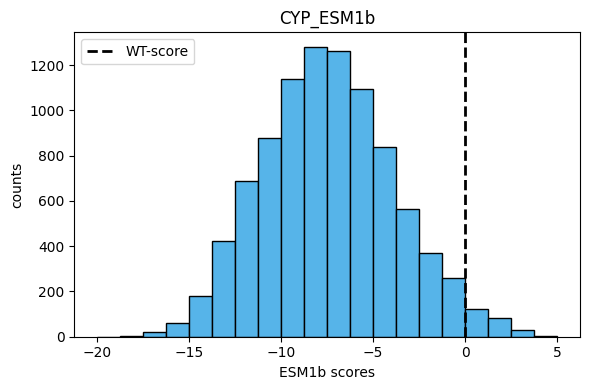

--> running ESM-IF
<-- ESM-IF run completed


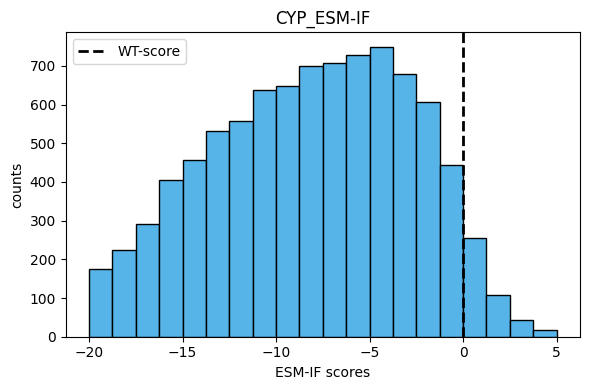

--> FunC-ESMs classification ...
<-- FunC-ESMs classification completed
--> Saving data ...
--> Data saved in FunC-ESMs_output folder


In [5]:
#@title <b><font color='#56b4e9'>MODEL RUN:</font> Variants and residues classification
#@markdown Run the cell to first run ESM1b and ESM-IF and generate scores for each variant. Then FunC-ESMs will be used to generate predictions for the query protein at variant and residue level.

mut_list,outscores_1B=ESM1B_pred(model_1B,alphabet_1B,sequence=query_sequence)

histogram_data(outscores_1B,range_data=[-20,5],xlabel='ESM1b scores',title=jobname+'_ESM1b',where_save=plot_folder,sequence=query_sequence)


mut_list,outscores_IF=ESMIF_pred(model_IF,alphabet_IF,sequence=sequence_structure,coords=coords_structure,cmplx=is_complex,chain_targer=chain_id)

histogram_data(outscores_IF,range_data=[-20,5],xlabel='ESM-IF scores',title=jobname+'_ESM-IF',where_save=plot_folder,sequence=query_sequence)

variants_class=classify_variants(outscores_1B,outscores_IF)

residues_class=classify_residues(variants_class)

### copy PDB, make df and print them in results folder

print('--> Saving data ...')
shutil.copy(f"/content/inputs/query_protein.pdb",f"FunC-ESMs_outputs/{output_name_pdb}")

df_esm1B=pd.DataFrame({'Mutation': np.array(mut_list).flatten(),
                        'ESM1b_scores' : outscores_1B.flatten()})

df_esmIF=pd.DataFrame({'Mutation': np.array(mut_list).flatten(),
                        'ESM1IF_scores' : outscores_IF.flatten()})

df_variants=pd.DataFrame({'Mutation': np.array(mut_list).flatten(),
                        'Variant-class ' : np.vectorize(alphabet_class_variant_d_l.get)(variants_class.flatten()),
                        'Variant-digit-class' : variants_class.flatten()})
res_list=[]
for i in range(0,len(query_sequence)):
  res_list.append(query_sequence[i]+str(i+1))

df_residues=pd.DataFrame({'Residue': np.array(res_list).flatten(),
                        'Residue-class ' : np.vectorize(alphabet_class_residue_d_l.get)(residues_class.flatten()),
                        'Residue-digit-class' : residues_class.flatten(),
                        '#-WT-like-variant' : count_class_variant_position(variants_class,0),
                        '#-SBI-variant' : count_class_variant_position(variants_class,1),
                        '#-Total-loss-variant' : count_class_variant_position(variants_class,2)})

if output_format== 'csv':
  df_esm1B.to_csv(f"FunC-ESMs_outputs/"+f"{jobname}_ESM1B_scores.csv",sep=',')
  df_esmIF.to_csv(f"FunC-ESMs_outputs/"+f"{jobname}_ESMIF_scores.csv",sep=',')
  df_variants.to_csv(f"FunC-ESMs_outputs/"+f"{jobname}_FunC-ESMs_variants_pred.csv",sep=',')
  df_residues.to_csv(f"FunC-ESMs_outputs/"+f"{jobname}_FunC-ESMs_residues_pred.csv",sep=',')

if output_format== 'excel':
  df_esm1B.to_excel(f"FunC-ESMs_outputs/"+f"{jobname}_ESM1B_scores.xlsx")
  df_esmIF.to_excel(f"FunC-ESMs_outputs/"+f"{jobname}_ESMIF_scores.xlsx")
  df_variants.to_excel(f"FunC-ESMs_outputs/"+f"{jobname}_FunC-ESMs_variants_pred.xlsx")
  df_residues.to_excel(f"FunC-ESMs_outputs/"+f"{jobname}_FunC-ESMs_residues_pred.xlsx")

print('--> Data saved in FunC-ESMs_output folder')

## <b><font color='#56b4e9'>Visualise the results: </font>


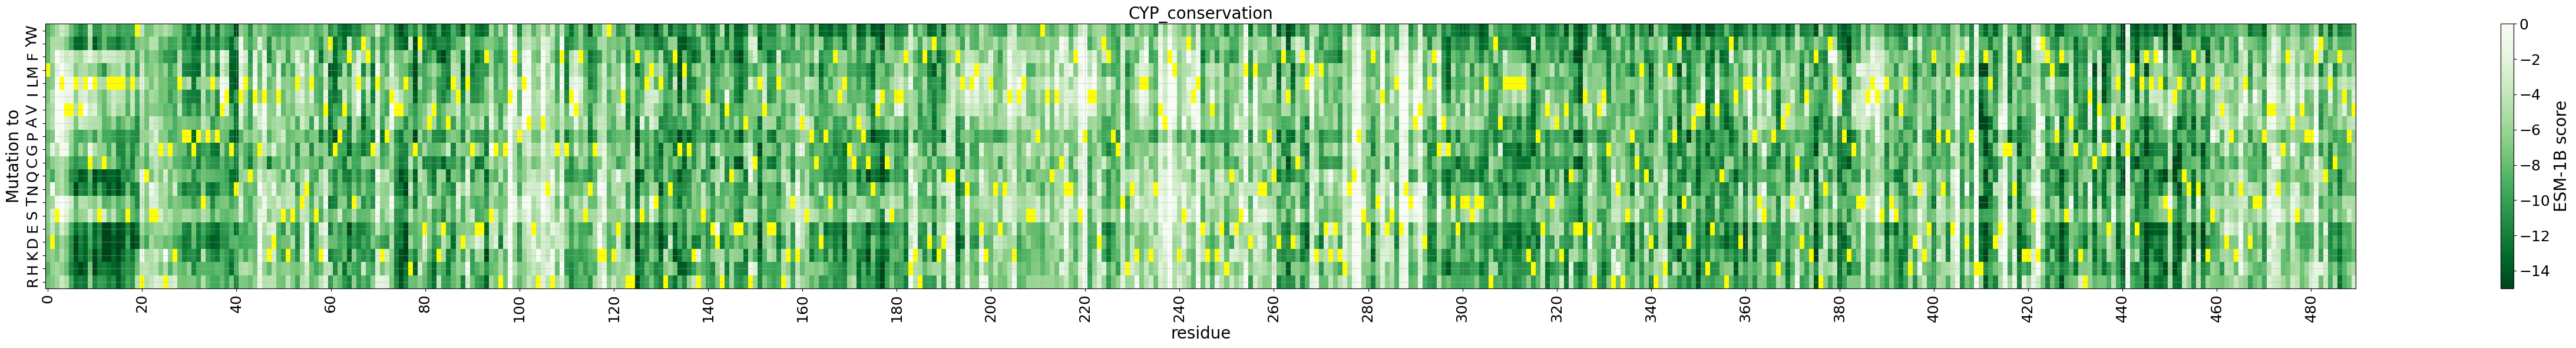

In [6]:
#@title <b>Conservation score (ESM-1b)</b>
#@markdown Visualise the ESM-1b variant score heatmap for the query sequence\
#@markdown \
#@markdown **Color keys:**
#@markdown - Light shade variants: non-detrimental / Dark shade variants : detrimental
#@markdown - <b><font color='grey'>Grey </font></b>: Missing positions
#@markdown - <b><font color='#F0E442'>YELLOW </font></b>: WT amino acid

#@markdown Changing the min_colormap value (suggested from -5 to -30) will make the heatmap closer to binary (~5) or more detailed (<<-5).

#@markdown **N.B.:** residue numeration in the figure starts from 0 (remember to add +1 for original residue numeration).

plot_width=50 #@param

min_colormap=-15 #@param

colour_map='Greens' #@param ["Blues", "Greens","Purples"]

heatmap_values_reordered(outscores_1B,'ESM-1B score',query_sequence,[0,len(query_sequence)-1],xtick_spacing=20,figs=[plot_width,6],where_save=plot_folder,title_figure=jobname+'_conservation',colour_map=colour_map,min_colour=min_colormap)

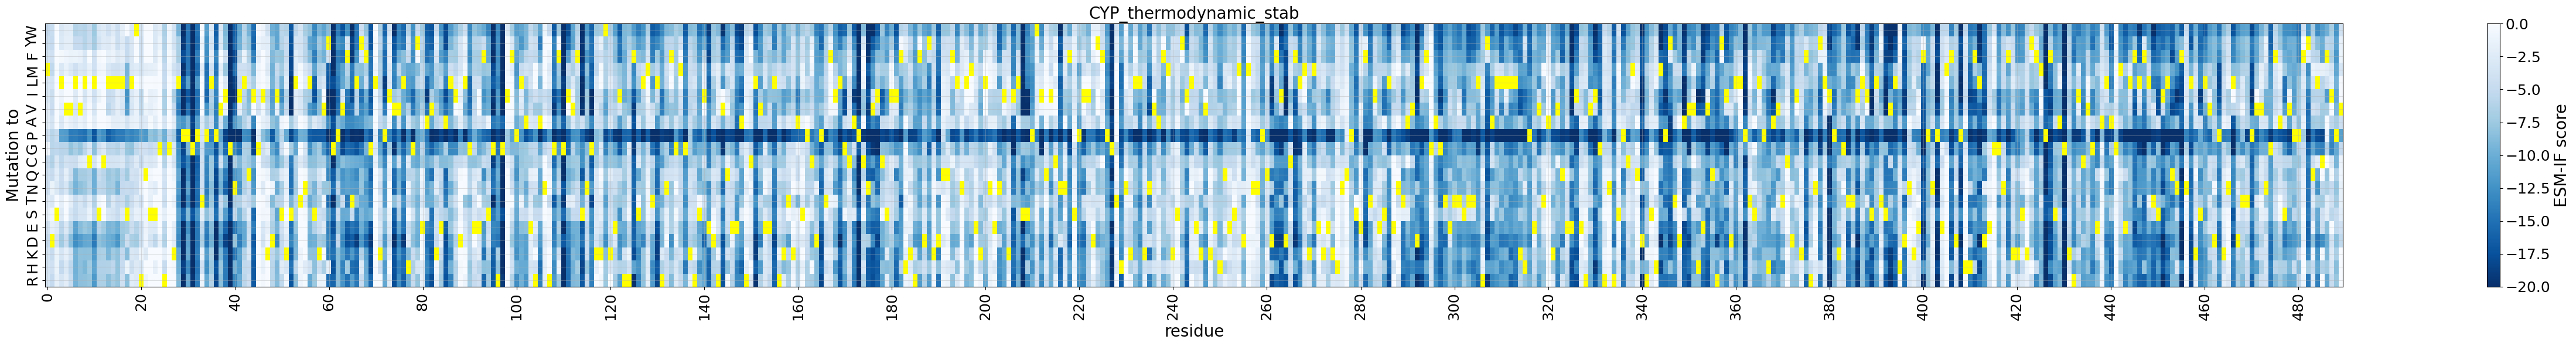

In [7]:
#@title <b> Stability changes score (ESM-IF)</b>
#@markdown Visualise the ESM-IF variant score heatmap for the uploaded query structure\
#@markdown \
#@markdown **Color keys:**
#@markdown - Light shade variants: stable / Dark shade variants : unstable
#@markdown - <b><font color='grey'>Grey </font></b>: Missing positions
#@markdown - <b><font color='#F0E442'>YELLOW </font></b>: WT amino acid

#@markdown Changing the min_colormap value (suggested from -5 to -30) will make the heatmap closer to binary (~5) or more detailed (<<-5).

#@markdown **N.B.:** residue numeration in the figure starts from 0 (remember to add +1 for original residue numeration).

plot_width=50 #@param

min_colormap=-20 #@param

colour_map='Blues' #@param ["Blues", "Greens","Purples"]

heatmap_values_reordered(outscores_IF,'ESM-IF score',query_sequence,[0,len(query_sequence)-1],xtick_spacing=20,figs=[plot_width,6],where_save=plot_folder,title_figure=jobname+'_thermodynamic_stab',colour_map=colour_map,min_colour=min_colormap)

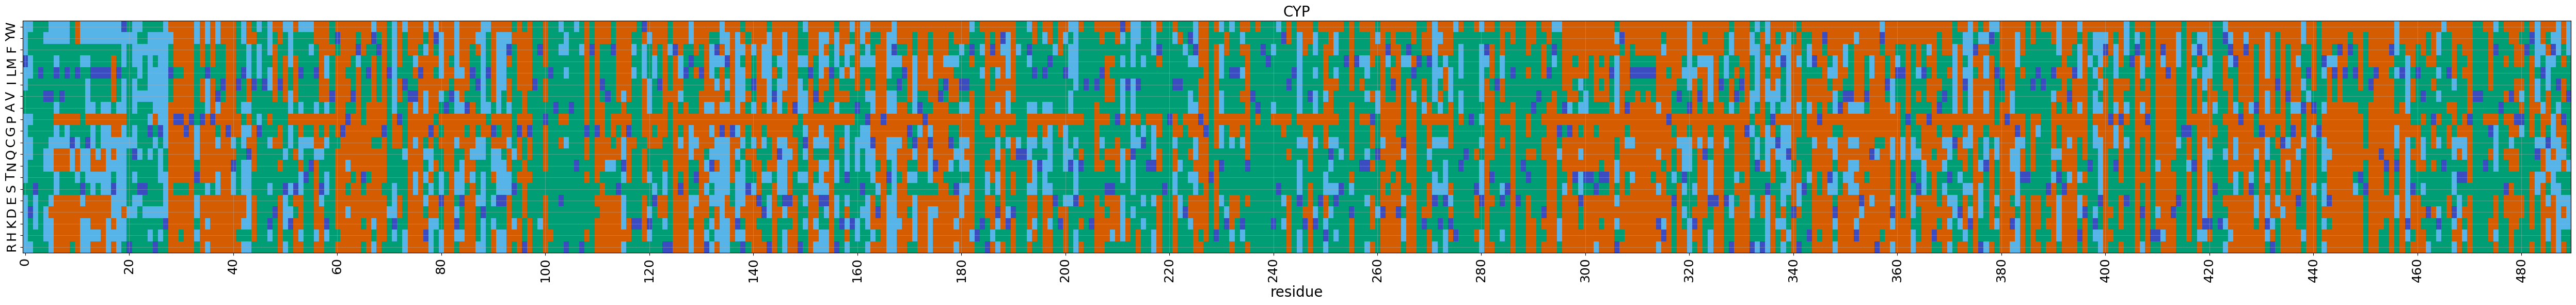

<ipython-input-2-a058c64b5c89>:284: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(where_save,title_figure+'_residue_class.pdf'),dpi=300,bbox_inches='tight')
<ipython-input-2-a058c64b5c89>:284: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(os.path.join(where_save,title_figure+'_residue_class.pdf'),dpi=300,bbox_inches='tight')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


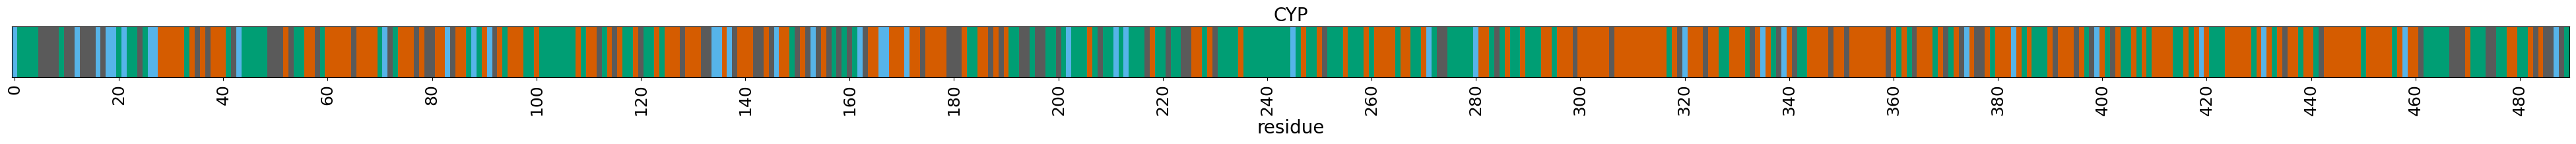

In [8]:
#@title <b><font color='#56b4e9'>Func-ESMs: </font>
#@markdown Visualise the results of the classification for variants and residues using the query sequence/structure\
#@markdown \
#@markdown **Color keys:**
#@markdown - <b><font color='#009E74'>GREEN </font></b>: **WT-like** (variants) and **Tolerant** (residues)
#@markdown - <b><font color='#56b4e9'>BLUE </font></b>: **stable-but-inactive** (variants) or **functionally-relevant** (residues)
#@markdown - <b><font color='#D55C00'>RED </font></b>: **total-loss** (variant) and **structurally-critical** (residue)
#@markdown - <b>GRAY</b>: Mixed (residue)

#@markdown \
#@markdown **N.B.:** residue numeration in the figure starts from 0 (remember to add +1 for original residue numeration).

plot_width=50 #@param

heatmap_classes_reordered(variants_class,'\u0394\u0394G [a.u]',query_sequence,[0,len(query_sequence)-1],WT_cmap='coolwarm',xtick_spacing=20,figs=[plot_width,6],where_save=plot_folder,title_figure=jobname,)

residues_classes_reordered(residues_class,[0,len(query_sequence)-1],title_figure=jobname,where_save=plot_folder,figs=[plot_width,1],xtick_spacing=20)

In [9]:
#@title <b><font color='#56b4e9'>DOWNLOAD ALL RESULTS </font>
#@markdown Run the cell to download predictions and figures for all proteins analysed in the current session as a zip file.
os.system( "zip -r {} {}".format( f"FunC-ESMs_outputs.zip" , f"FunC-ESMs_outputs" ) )
files.download(f"FunC-ESMs_outputs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<b><font color='#56b4e9'>EXTRA </font></b>

\\

**Known problems:**

- The input structure must be a predicted structure from AlphaFold2 if possible. This is necessary to ensure maximum prediction quality as ESM-IF has been trained using the backbone from AlphaFold2.

- The maximum size of proteins that can be used in the ESM-1B ESM-IF Colab implementation is 1023 residues, larger proteins cannot currently be handled by the Colab implementation.



\\

**License:**

ESM models, the notebook code and FunC-ESMs source code are licensed under the MIT license found in the LICENSE file in the root directory of the GitHub page.

\\

**Bugs:**

For any bugs please report the issue on the project [Github](https://github.com/KULL-Centre/_2024_cagiada-jonsson-func/tree/main) or contact one of the listed authors in the connected [manuscript](https://doi.org/).

\\

**Citing this work:**

If you use our model please cite:

If you use our model please cite:

Matteo Cagiada, Nicolas Jonsson, and Kresten Lindorff-Larsen. 2023. “Decoding molecular mechanisms for loss of function variants in the human proteome” (add details upon publication).
```

@ARTICLE{Cagiada2024-jo,
  title     = "Decoding molecular mechanisms for loss of function variants in the human proteome",
  author    = "Cagiada, Matteo and Jonsson, Nicolas and Lindorff-Larsen, Kresten",
  journal   = "",
  publisher = "",
  volume    =  ,
  year      =  2024,
  language  = "en"
}
```
